In [1]:
import numpy as np
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import os
import ROOT
from ROOT import gSystem, gInterpreter
import approximator.particles_trajectory_generator as ptg
import approximator.runner as ap_runnner
import data.bunch_configuration as buc

sns.set_style("whitegrid")

home = "/home/rafalmucha/Pobrane/optic/"
file_name = "parametrization_6500GeV_0p4_185_reco"
approximator_name = "ip5_to_station_220_h_1_lhcb1"
path_to_project = home+"/optics_generator_python"
path_to_file = home+"/2016/" + file_name + ".root"

Welcome to JupyROOT 6.16/00


In [2]:
approximator = ap_runnner.get_approximator(path_to_project, path_to_file, approximator_name)

Error in <TCling::RegisterModule>: cannot find dictionary module FitCint_rdict.pcm


In [3]:
# Parameters of bunch
x_mean = 0.0
sigma_x = 10e-6
theta_x_mean = 0
sigma_theta_x = 10e-6
y_mean = 0.0
sigma_y = 10e-6
theta_y_mean = 0.00
sigma_theta_y = 10e-6
pt_mean = -0.075
sigma_pt = 0.075

particles_number = 1000

In [4]:
bunch_configuration = buc.BunchConfiguration.from_sigma(x_mean, sigma_x, particles_number,
                                                        theta_x_mean, sigma_theta_x, 1,
                                                        y_mean, sigma_y, 1,
                                                        theta_y_mean, sigma_theta_y, 1,
                                                        pt_mean, sigma_pt, 1)

In [5]:
output = ptg.generate_random_particles(approximator, bunch_configuration)

In [6]:
output["end"].shape

(1000, 5)

In [7]:
output["start"].shape

(1000, 5)

In [8]:
# Names of segments, like MQXA.3R5
start_segment_name = "start"
end_segment_name = "end"

if start_segment_name != "start":
    output[start_segment_name].T[1] -= 1
    
output_matrix = output[end_segment_name]
input_matrix = output[start_segment_name]

In [9]:
def generate_dataset(x_name, x_index, y_name, y_index, input_filtered, output):
    turn_name = "turn"
    
    turn_in = np.full(input_filtered.shape[0], 0)
    x_in = input_filtered.T[x_index]
    y_in = input_filtered.T[y_index]
    frame_in = pd.DataFrame(data={x_name: x_in, y_name: y_in, turn_name: turn_in})

    turn_out = np.full(output.shape[0], 1)
    x_out = output.T[x_index]
    y_out = output.T[y_index]
    frame_out = pd.DataFrame(data={x_name: x_out, y_name: y_out, turn_name: turn_out})

    data_frame = frame_out.append(frame_in)
    
    mapping = {0: 'IN: which passed to OUT', 1: 'OUT'}
    x = data_frame.replace({"turn": mapping})
    
    return x

index_map = {
    "x": 0,
    "theta x": 1,
    "y": 2,
    "theta y": 3,
    "t": 4,
    "pt": 5
}
meters = " [m]"
radians = " [rad]"
seconds = " [s]"
energy = " [TeV]"
no_unit = " "
unit_map = {
    "x": meters,
    "theta x": radians,
    "y": meters,
    "theta y": radians,
    "t": seconds,
    "pt": no_unit,
    "s": meters,
    "e": energy,
    "alfa x": radians,
    "alfa y": radians
}


def find_min_and_max(x_name, y_name, matrixes):
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    
    matrix1 = matrixes[0]
    
    x_min = np.min(matrix1.T[x_index])
    y_min = np.min(matrix1.T[y_index])
    
    x_max = np.max(matrix1.T[x_index])
    y_max = np.max(matrix1.T[y_index])
    
    for matrix2 in matrixes[1:]:
        x_min = min(np.min(matrix2.T[x_index]), x_min)
        y_min = min(np.min(matrix2.T[y_index]), y_min)
        
        x_max = max(np.max(matrix2.T[x_index]), x_max)
        y_max = max(np.max(matrix2.T[y_index]), y_max)
    
    return x_min, x_max, y_min, y_max



def plot_with_turn(x_name, y_name, input_matrix, output_matrix, x_pos, y_pos, axes, x_scale=1e-3, y_scale=1e-5):
    title_sufix = "\n" + file_name + "\n" + approximator_name
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    turn_name = "turn"
    turn_index = 1

    x_full_name = x_name + unit_map[x_name]
    y_full_name = y_name + unit_map[y_name]
    data_frame = generate_dataset(x_full_name, x_index, y_full_name, y_index, input_matrix, output_matrix)

    title = x_name + " and " + y_name + " parameter:" + title_sufix
    
    matrixes = [input_matrix, output_matrix]
    
    x_min, x_max, y_min, y_max = find_min_and_max(x_name, y_name, matrixes)

    delta_x = x_max - x_min
    delta_y = y_max - y_min
    
    axes[x_pos][y_pos].set_xlim(x_min - 0.25 * delta_x, x_max + 0.25 * delta_x)
    axes[x_pos][y_pos].set_ylim(y_min - 0.25 * delta_y, y_max + 0.25 * delta_y)
    
    sns.scatterplot(x=x_full_name, y=y_full_name,
                    data=data_frame, ax=axes[x_pos][y_pos], hue="turn").set_title(title)

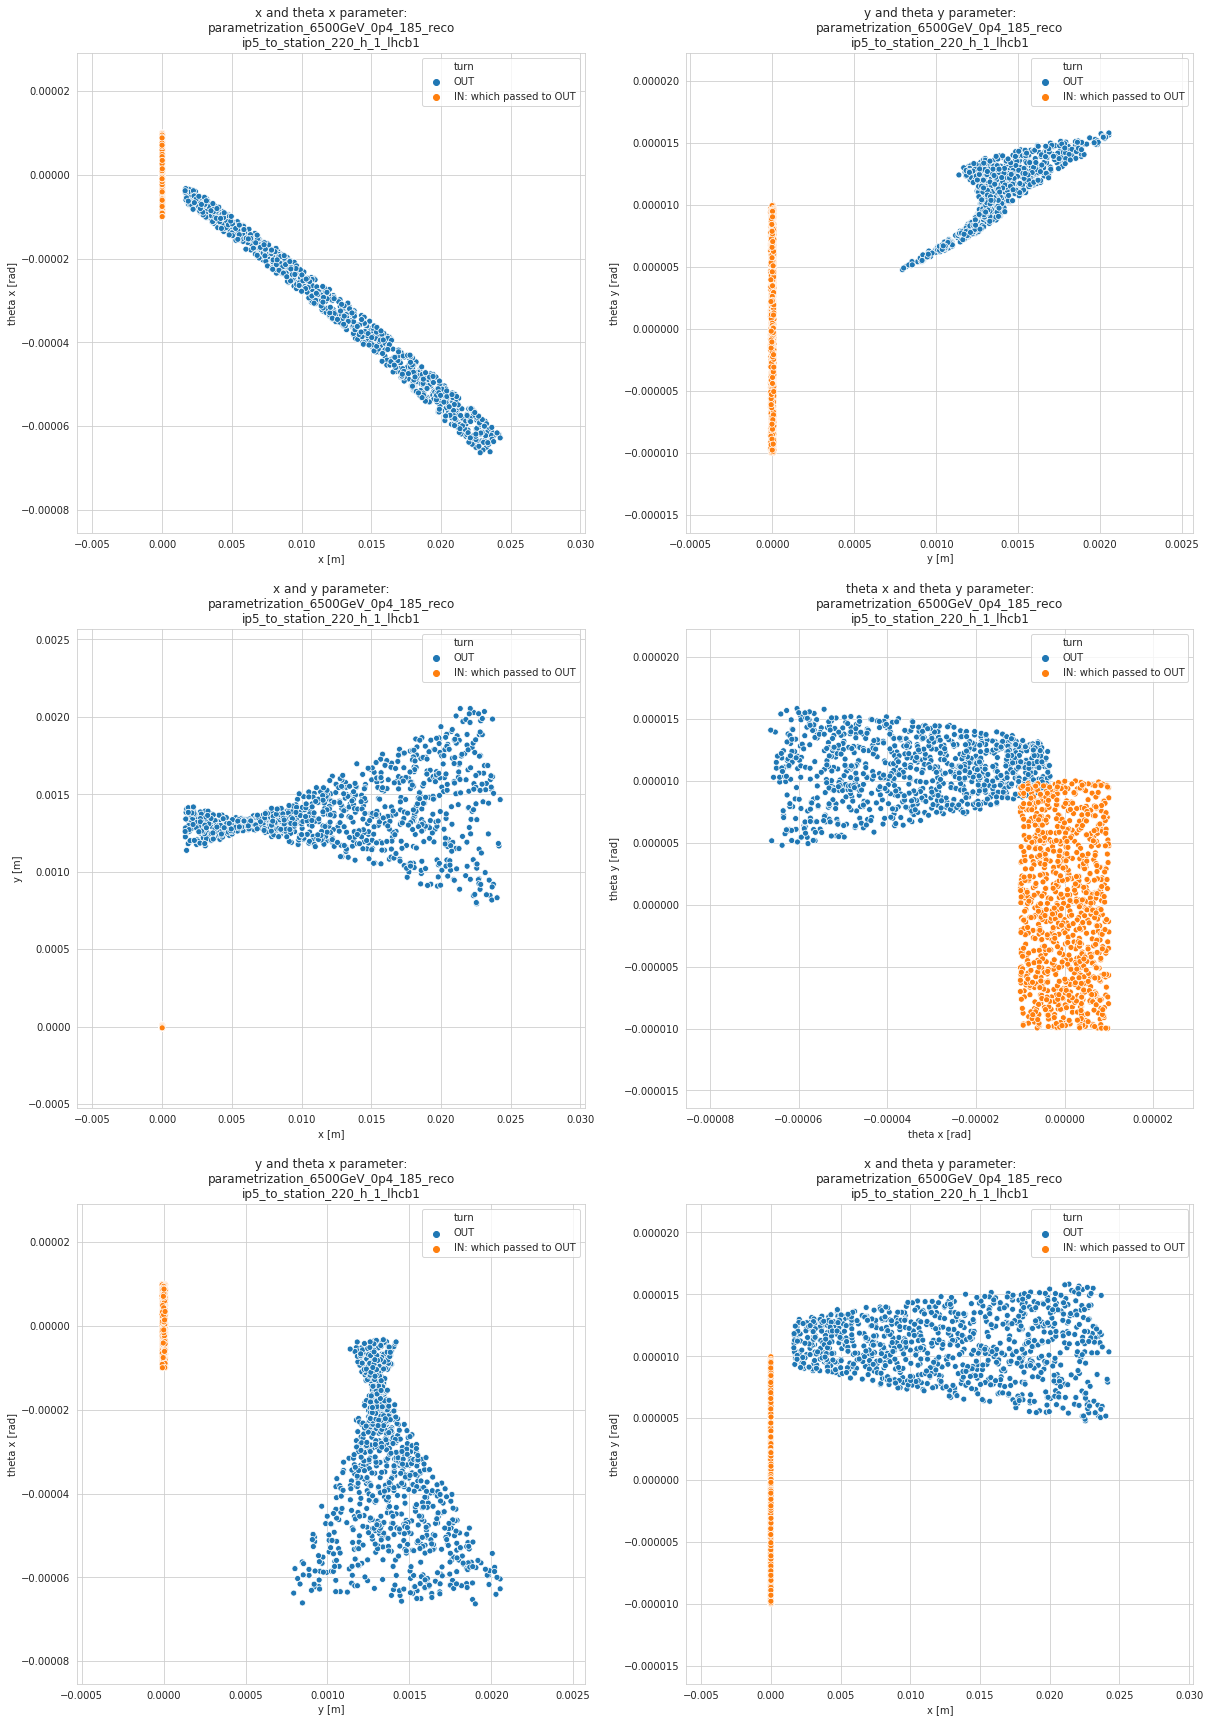

In [10]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot_with_turn("x", "theta x", input_matrix, output_matrix, 0, 0, axes, 1e-3, 5e-6)

plot_with_turn("y", "theta y", input_matrix, output_matrix, 0, 1, axes, 1e-3, 5e-6)

plot_with_turn("x", "y", input_matrix, output_matrix, 1, 0, axes, 1e-3, 1e-3)

plot_with_turn("theta x", "theta y", input_matrix, output_matrix, 1, 1, axes, 5e-6, 5e-6)

plot_with_turn("y", "theta x", input_matrix, output_matrix, 2, 0, axes, 1e-3, 1e-5)

plot_with_turn("x", "theta y", input_matrix, output_matrix, 2, 1, axes, 1e-3, 1e-5)



In [11]:
def plot(x_name, y_name, x_name_prefix, y_name_prefix, x_matrix, y_matrix, plot_axes, plot_x_pos, plot_y_pos):
    
    # Get names of axis and title of plot
    
    x_full_name = x_name_prefix + x_name + unit_map[x_name]
    y_full_name = y_name_prefix + y_name + unit_map[y_name]
    
    title = x_name_prefix + x_name + " and " + y_name_prefix + y_name + " parameter"
    
    # Get vectors and their properties
    
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    
    vector_x = x_matrix.T[x_index]
    vector_y = y_matrix.T[y_index]
    
    frame = pd.DataFrame(data={x_full_name: vector_x, y_full_name: vector_y})
    
    # Set scale and range of axis

    x_min = np.min(vector_x)
    
    x_max = np.max(vector_x)

    y_min = np.min(vector_y)

    y_max = np.max(vector_y)
    
    delta_x = x_max - x_min
    delta_y = y_max - y_min
    
    axes[plot_x_pos][plot_y_pos].set_xlim(x_min - 0.25 * delta_x, x_max + 0.25 * delta_x)
    axes[plot_x_pos][plot_y_pos].set_ylim(y_min - 0.25 * delta_y, y_max + 0.25 * delta_y)
    
    sns.scatterplot(x=x_full_name, y=y_full_name,
                    data=frame, ax=axes[plot_x_pos][plot_y_pos]).set_title(title)

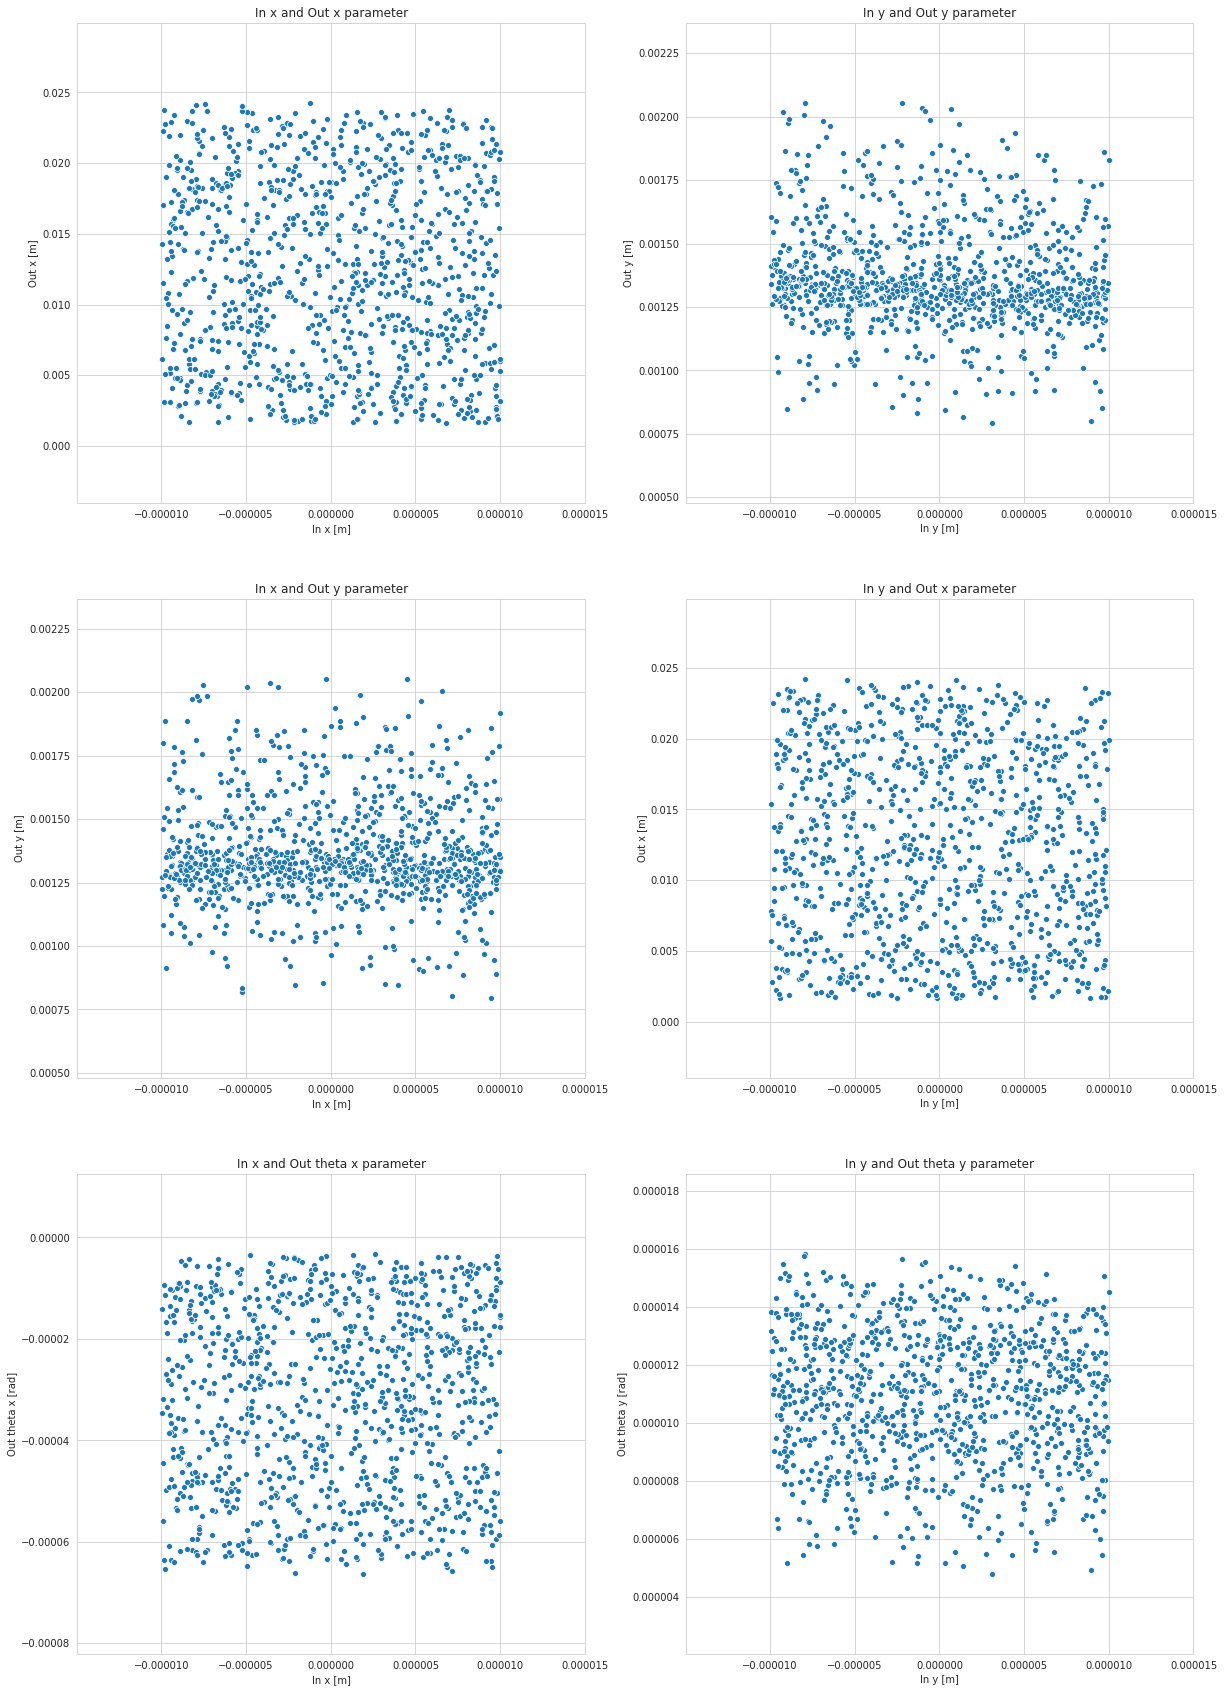

In [12]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot("x", "x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot("y", "y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot("x", "y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot("y", "x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)

plot("x", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 2, 0)

plot("y", "theta y", "In ", "Out ",  input_matrix, output_matrix, axes, 2, 1)

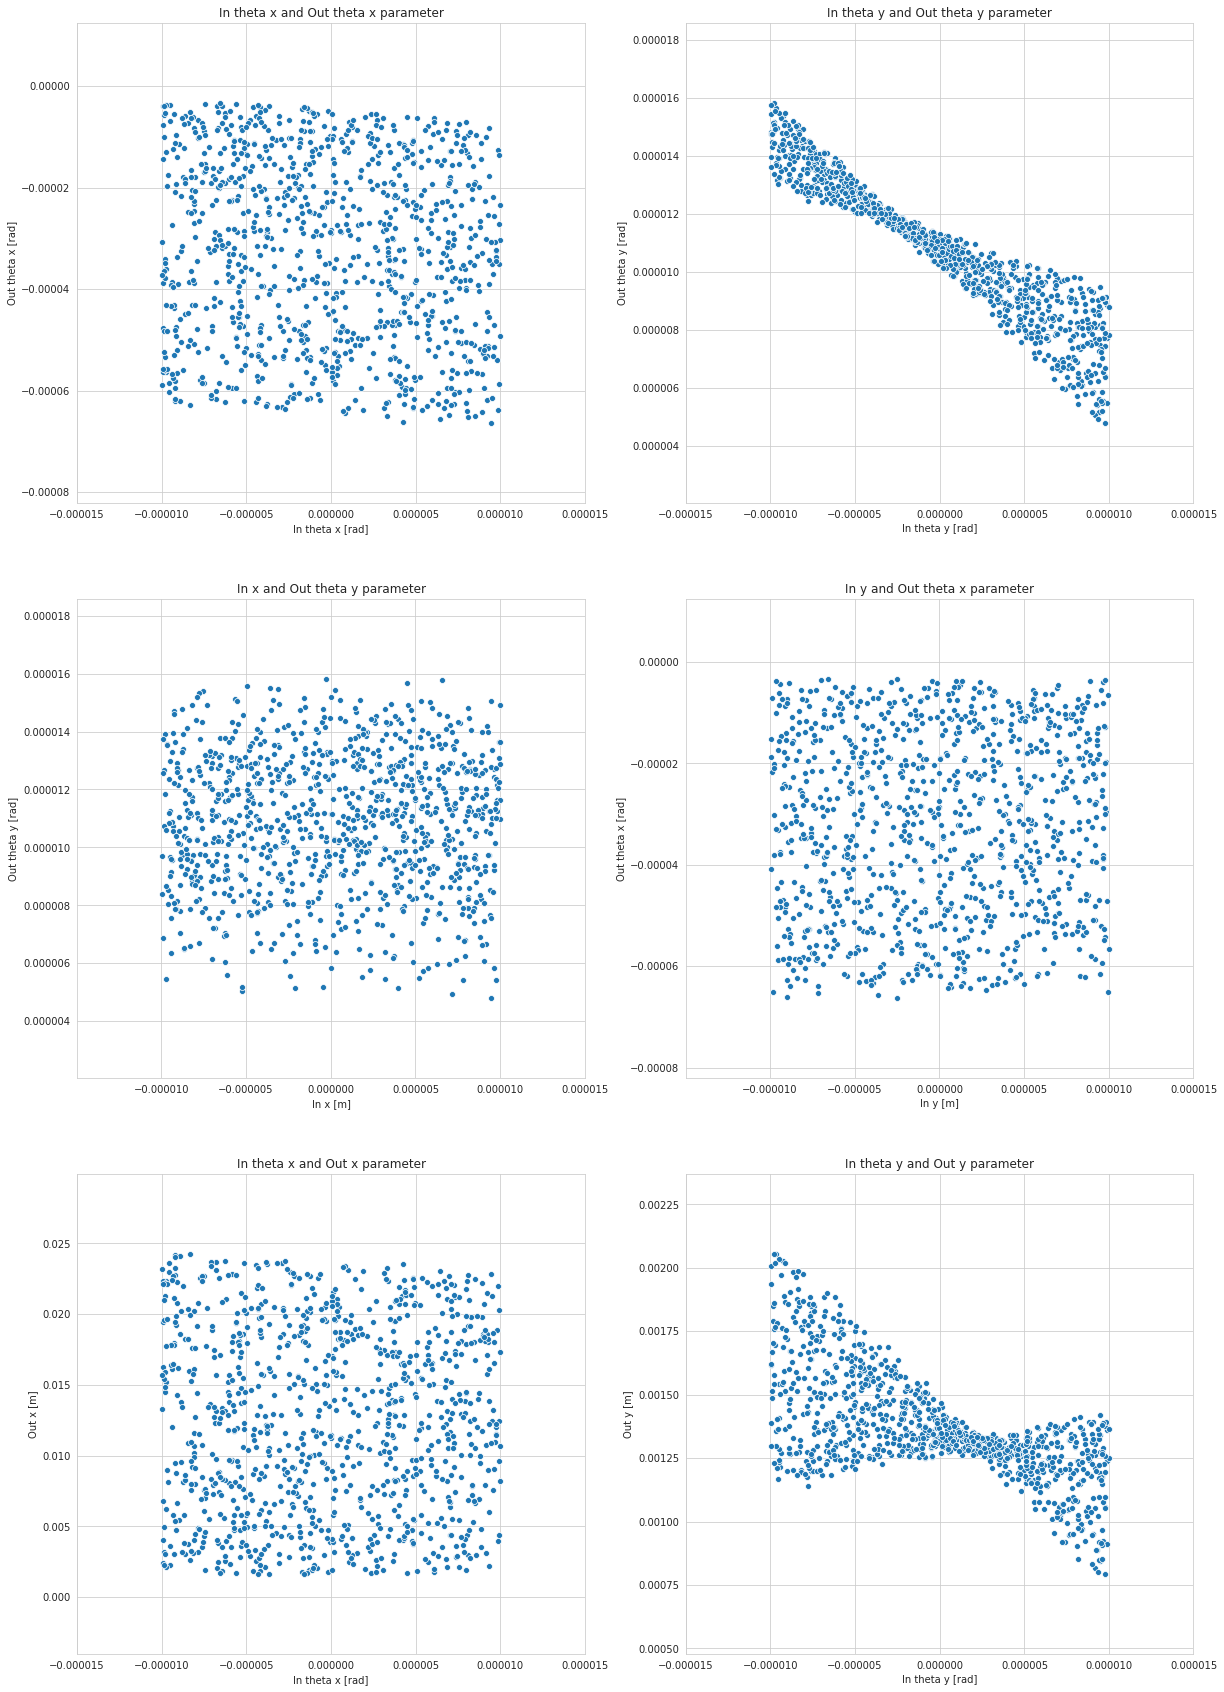

In [13]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot("theta x", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot("theta y", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot("x", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot("y", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)

plot("theta x", "x", "In ", "Out ", input_matrix, output_matrix, axes, 2, 0)

plot("theta y", "y", "In ", "Out ", input_matrix, output_matrix, axes, 2, 1)


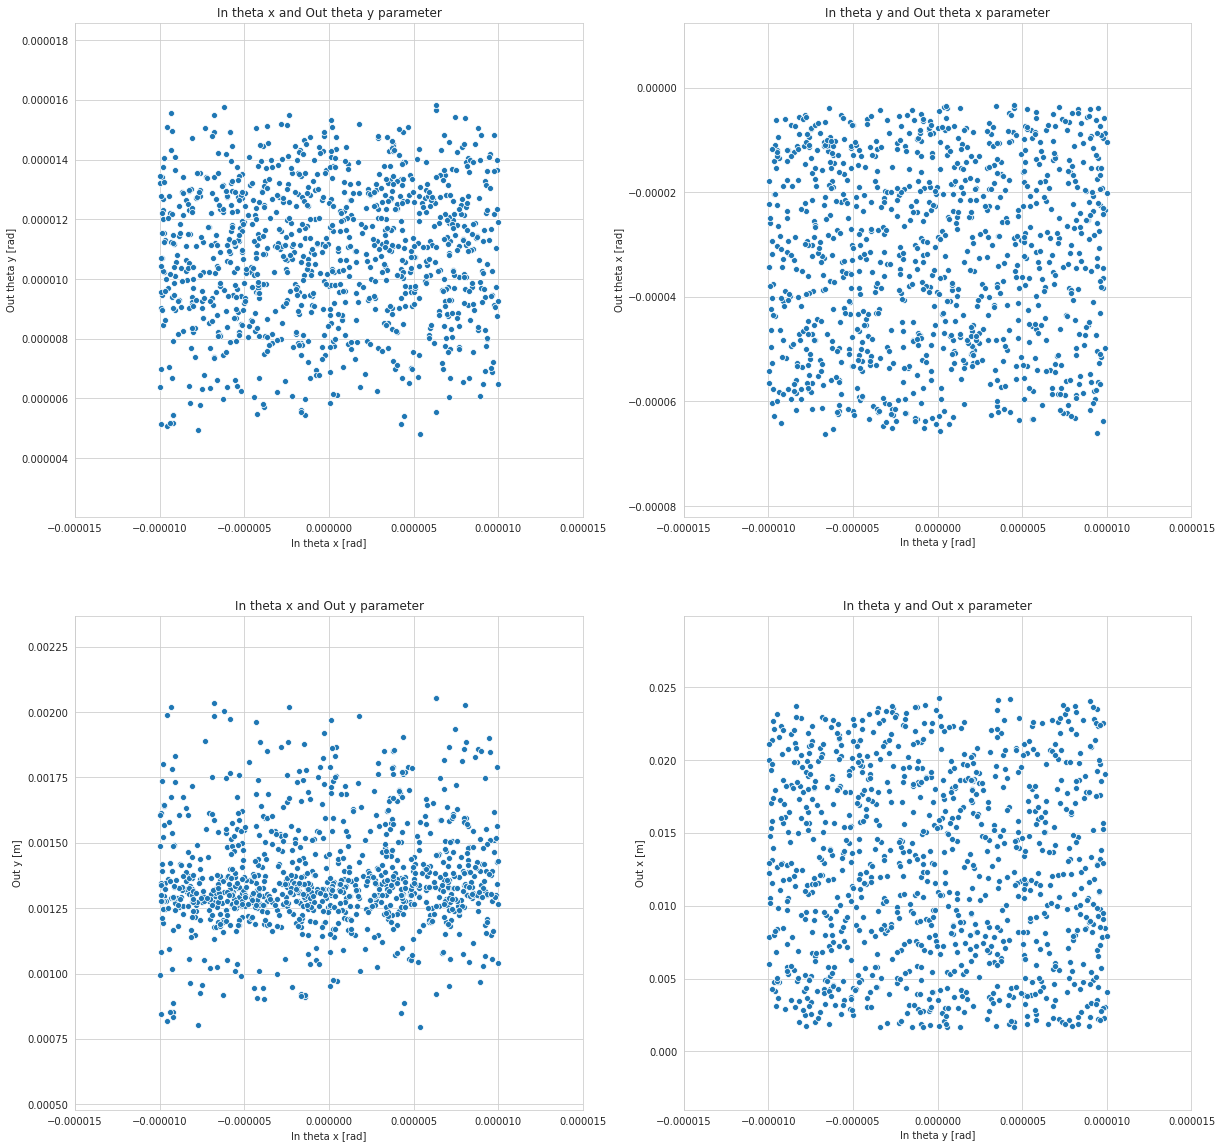

In [14]:
f, axes = plt.subplots(2, 2)

fig = plt.gcf()
fig.set_size_inches(20,20)

plot("theta x", "theta y", "In ", "Out ", input_matrix, output_matrix, axes, 0, 0)

plot("theta y", "theta x", "In ", "Out ", input_matrix, output_matrix, axes, 0, 1)

plot("theta x", "y", "In ", "Out ", input_matrix, output_matrix, axes, 1, 0)

plot("theta y", "x", "In ", "Out ", input_matrix, output_matrix, axes, 1, 1)